## Installing and importing the necessary Libraries


In [ ]:
## Installing sentence transformers
!pip install sentence-transformers==2.7.0

In [ ]:
## Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
import random
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

## Converting 'mpnet-base' to Sentence Transformer by performing pooling on the token embeddings


In [ ]:
## using pretrained microsoft/mpnet-base model
transformer_model = models.Transformer('microsoft/mpnet-base')
## using mean pool function over the token embeddings to get fixed dimension embeddings
pooling_model = models.Pooling(transformer_model.get_word_embedding_dimension(),pooling_mode_mean_tokens=True)
## Creating the sentence transformer model
model_base = SentenceTransformer(modules=[transformer_model, pooling_model])


## Reading in the data

In [ ]:
# mount google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Reading in the Airlines Twitter data in
df = pd.read_csv('/content/drive/MyDrive/Tweets.csv' )

## Classifying the reviews as numeric labels

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#Classifying the positive reviews as class 2 , neutral reviews as class 1 and negative reviews as class 0 under column "sentiment"
df['sentiment'] = df['airline_sentiment'].apply(lambda rating : 2 if rating =="positive" else (1 if rating=="neutral" else 0))
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


In [ ]:
## Renaming "text" as "Text"
df1=df.rename(columns={"text": "Text"})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  Text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Data Distribution

In [ ]:
df1.sentiment.value_counts(ascending=True)

sentiment
2    2363
1    3099
0    9178
Name: count, dtype: int64

<Axes: ylabel='Type'>

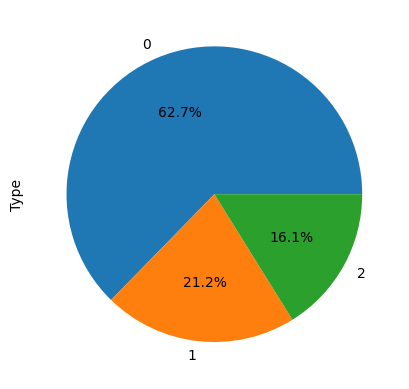

In [ ]:
df1.groupby('sentiment').size().plot(kind='pie',
                                       y = "sentiment",
                                       label = "Type",
                                       autopct='%1.1f%%')

## Preparing the data for encoding

In [ ]:
# Splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df1['Text'],
                                                    df1['sentiment'],
                                                    test_size=0.1,
                                                    random_state=21,
                                                    stratify=df1['sentiment'])



In [ ]:
## Converting to list for downstream processing
X_train_list=X_train.tolist()
X_test_list=X_test.tolist()

## Encoding the texts using the Base Sentence Transformer Model and running Classification Algorithms

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model_base.encode(X_train_list, show_progress_bar = True)
vect_test = model_base.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[851  53  14]
 [ 95 191  24]
 [ 34  34 168]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8684    0.9270    0.8967       918
           1     0.6871    0.6161    0.6497       310
           2     0.8155    0.7119    0.7602       236

    accuracy                         0.8265      1464
   macro avg     0.7903    0.7517    0.7689      1464
weighted avg     0.8215    0.8265    0.8224      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass',random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[860  45  13]
 [ 95 190  25]
 [ 32  38 166]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8713    0.9368    0.9029       918
           1     0.6960    0.6129    0.6518       310
           2     0.8137    0.7034    0.7545       236

    accuracy                         0.8306      1464
   macro avg     0.7937    0.7510    0.7697      1464
weighted avg     0.8249    0.8306    0.8258      1464



## Encoding the texts using the Base Sentence Transformer Model finetuned on CosineSimilarityLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on CosineSimilarityLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text sentence and appending to triplet with target similarity score as 1.0
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=1.0))
      # For each positive sentiment text, randomly selecting a negative sentiment text and appending to triplet with target similarity score as 0
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
      # For each positive sentiment text, randomly selecting a neutral sentiment text and appending to triplet with target similarity score as 0.5
      neuSentence = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[currentSentence, neuSentence], label=0.5))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as CosineSimilarityLoss
model = model_base
train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
# Finetuning the model based on CosineSimilarityLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[843  66   9]
 [ 57 230  23]
 [ 20  22 194]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9163    0.9183    0.9173       918
           1     0.7233    0.7419    0.7325       310
           2     0.8584    0.8220    0.8398       236

    accuracy                         0.8654      1464
   macro avg     0.8327    0.8274    0.8299      1464
weighted avg     0.8661    0.8654    0.8657      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[837  73   8]
 [ 59 227  24]
 [ 18  24 194]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9158    0.9118    0.9138       918
           1     0.7006    0.7323    0.7161       310
           2     0.8584    0.8220    0.8398       236

    accuracy                         0.8593      1464
   macro avg     0.8249    0.8220    0.8232      1464
weighted avg     0.8610    0.8593    0.8600      1464



## Encoding the texts using the Base Sentence Transformer Model finedtuned on CoSentLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on CoSentLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text sentence and appending to triplet with target similarity score as 1.0
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=1.0))
      # For each positive sentiment text, randomly selecting a negative sentiment text and appending to triplet with target similarity score as 0
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=-1.0))
      # For each positive sentiment text, randomly selecting a neutral sentiment text and appending to triplet with target similarity score as 0.5
      neuSentence = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[currentSentence, neuSentence], label=0))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as CoSENTLoss
model = model_base
train_loss = losses.CoSENTLoss(model)

In [ ]:
# Finetuning the model based on CoSENTLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[833  72  13]
 [ 58 232  20]
 [ 18  28 190]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9164    0.9074    0.9119       918
           1     0.6988    0.7484    0.7227       310
           2     0.8520    0.8051    0.8279       236

    accuracy                         0.8572      1464
   macro avg     0.8224    0.8203    0.8208      1464
weighted avg     0.8599    0.8572    0.8583      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass',random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[831  76  11]
 [ 57 234  19]
 [ 17  29 190]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9182    0.9052    0.9117       918
           1     0.6903    0.7548    0.7211       310
           2     0.8636    0.8051    0.8333       236

    accuracy                         0.8572      1464
   macro avg     0.8240    0.8217    0.8220      1464
weighted avg     0.8612    0.8572    0.8587      1464



## Encoding the texts using the Base Sentence Transformer Model finedtuned on BatchAllTripletLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on TripletLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["sentiment"] == 2]
  train_neg = train.loc[train["sentiment"] == 0]
  train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      anchor = train_pos_text_list[y]
      triplets.append(InputExample(texts=[anchor], label=2))
      # For each anchor text, randomly selecting another text from the same class as the anchor and appending to triplet
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[posSentence], label=2))
      # For each anchor text, randomly selecting another text from a different class(neutral sentiment class) as of the anchor and appending to triplet
      negSentence1 = random.choice(train_neu_text_list)
      triplets.append(InputExample(texts=[negSentence1], label=1))
      # For each anchor text, randomly selecting another text from a different class(negative sentiment class) as of the anchor and appending to triplet
      negSentence2 = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[negSentence2], label=0))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as BatchAllTripletLoss
model = model_base
train_loss = losses.BatchAllTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchAllTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding train and test data using finetuned model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[843  67   8]
 [ 65 230  15]
 [ 20  28 188]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9084    0.9183    0.9133       918
           1     0.7077    0.7419    0.7244       310
           2     0.8910    0.7966    0.8412       236

    accuracy                         0.8613      1464
   macro avg     0.8357    0.8189    0.8263      1464
weighted avg     0.8631    0.8613    0.8617      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass',random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[843  67   8]
 [ 68 228  14]
 [ 21  29 186]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9045    0.9183    0.9114       918
           1     0.7037    0.7355    0.7192       310
           2     0.8942    0.7881    0.8378       236

    accuracy                         0.8586      1464
   macro avg     0.8341    0.8140    0.8228      1464
weighted avg     0.8603    0.8586    0.8588      1464



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchHardSoftMarginTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchHardSoftMarginTripletLoss
model = model_base
train_loss = losses.BatchHardSoftMarginTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchHardSoftMarginTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[841  68   9]
 [ 72 222  16]
 [ 23  28 185]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8985    0.9161    0.9072       918
           1     0.6981    0.7161    0.7070       310
           2     0.8810    0.7839    0.8296       236

    accuracy                         0.8525      1464
   macro avg     0.8259    0.8054    0.8146      1464
weighted avg     0.8532    0.8525    0.8523      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[841  68   9]
 [ 70 224  16]
 [ 21  28 187]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9024    0.9161    0.9092       918
           1     0.7000    0.7226    0.7111       310
           2     0.8821    0.7924    0.8348       236

    accuracy                         0.8552      1464
   macro avg     0.8281    0.8104    0.8184      1464
weighted avg     0.8562    0.8552    0.8553      1464



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchHardTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchHardTripletLoss
model = model_base
train_loss = losses.BatchHardTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchHardTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
Confusion Matrix - 
 [[850  60   8]
 [ 69 222  19]
 [ 28  26 182]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8976    0.9259    0.9115       918
           1     0.7208    0.7161    0.7184       310
           2     0.8708    0.7712    0.8180       236

    accuracy                         0.8566      1464
   macro avg     0.8297    0.8044    0.8160      1464
weighted avg     0.8558    0.8566    0.8556      1464



In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[851  59   8]
 [ 71 220  19]
 [ 28  24 184]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8958    0.9270    0.9111       918
           1     0.7261    0.7097    0.7178       310
           2     0.8720    0.7797    0.8233       236

    accuracy                         0.8572      1464
   macro avg     0.8313    0.8055    0.8174      1464
weighted avg     0.8560    0.8572    0.8560      1464



## Encoding the texts using the Base Sentence Transformer Model finetuned on BatchSemiHardTripletLoss and running Classification Algorithms

In [ ]:
# Defining Trainloss with loss as BatchSemiHardTripletLoss
model = model_base
train_loss = losses.BatchSemiHardTripletLoss(model)

In [ ]:
# Finetuning the model based on BatchSemiHardTripletLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

In [ ]:
# Running LGBoost algorithm for classification
# define the model
model_lgbm = LGBMClassifier(objective='multiclass', random_state=5)
model_lgbm.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_lgbm.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_lgbm.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 768
[LightGBM] [Info] Start training from score -0.466972
[LightGBM] [Info] Start training from score -1.552714
[LightGBM] [Info] Start training from score -1.823684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Confusion Matrix - 
 [[862  48   8]
 [ 78 214  18]
 [ 28  22 186]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8905    0.9390    0.9141       918
           1     0.7535    0.6903    0.7205       310
           2     0.8774    0.7881    0.8304       236

    accuracy                         0.8620      1464
   macro avg     0.8405    0.8058    0.8217      1464
weighted avg     0.8594    0.8620    0.8596      146

In [ ]:
# Running XGBoost algorithm for classification
model_xgb = XGBClassifier(objective='multiclass', random_state=5)
model_xgb.fit(vect_train, y_train)
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
y_pred_proba = model_xgb.predict_proba(vect_test)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[862  48   8]
 [ 74 217  19]
 [ 25  25 186]]
Classification report - 
               precision    recall  f1-score   support

           0     0.8970    0.9390    0.9175       918
           1     0.7483    0.7000    0.7233       310
           2     0.8732    0.7881    0.8285       236

    accuracy                         0.8641      1464
   macro avg     0.8395    0.8090    0.8231      1464
weighted avg     0.8617    0.8641    0.8620      1464

